# MPlot tutorial

The MPlot is used to check the distance between subsequence pairs into a time series according to a window size. This notebooks is a tutorial of how to use the different methods defined in mplots.ipyn for the specific case of 'PulsusParadoxus'.

## What is an MPlot?
MPlots were introduced by Eamonn Keogh and has a lot of research behind. The code in this notebook is mainly inspired in the XXVI paper:

- [IEEE - Matrix Profile XXVI: Mplots: Scaling Time Series Similarity Matrices to Massive Data](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10027730)

and following the guidelines of the example of use repository 

- [Zach Zimmerman - mplots-explorer (GitHub)](https://github.com/zpzim/mplot-explorer)

It also integrates methods of Stumpy:
- [Tutorial: The Matrix Profile](https://stumpy.readthedocs.io/en/latest/Tutorial_The_Matrix_Profile.html#Time-Series-with-Length-n-=-13)

Feel free of modifying the parameters and open issue in case of error!


**Note**

For the example in this notebook, the instructions in [Introducing Mplots: Scaling Time Series Recurrence Plots to Massive Datasets](https://web.archive.org/web/20240125145941id_/https://assets.researchsquare.com/files/rs-3651179/v1_covered_ef5f7e93-ace3-4376-b6f6-3021b43d586c.pdf?c=1701243102) have been followed. You can check more examples in [MPlots-pdf-Catalog](https://drive.google.com/file/d/1fjWUzVQf-8XmS5epDa_ulm4-bDX51Vxv/view). You will also find lots more datasets at his GoogleDrive. [This powerpoint](https://www.slideserve.com/mickie/ucr-time-series-semantic-segmentation-archive-powerpoint-ppt-presentation) explains the content of some of them in a simple way, including the Pulsus Paradoxus dataset.

## Notebook configuration
### Parameters

The parameters in this notebook are only some of the input parameters you can define for the *06-Mplot* notebook. In that notebook the configuration parameters are included in the first cell and fully explained as needed. 

Here you got:

- `print_flag`. If `True` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `cuda_device`. Integer used to define the GPU machine to be used for computation. Please ensure it is an id number valid for the built docker (check your .env file to know the valid ids)
- `execute_01`. Put this flag to true in case you have never executed the 01_<> notebook for the PulsusParadoxus dataset. Please change it to false one the celss in the section `Execute '1` have already been executed. It does not take very long, but it is some time ;).

In [91]:
#| export
# Configuration paramaters
print_flag                    = True
reset_kernel                  = False
check_memory_usage            = True
time_flag                     = True
cuda_device                   = 1

In [92]:
print("--- Check parameters ---")
print(
    "print_flag (for printing or not messages):", print_flag, "\n",
    "check_memory_usage (for evaluating the current gpu memor status)", check_memory_usage, "\n",
    "time_flag:", time_flag, "\n",
    "reset_kernel:",reset_kernel, "\n",
    "cuda_device", cuda_device, "\n"
)

--- Check parameters ---
print_flag (for printing or not messages): True 
 check_memory_usage (for evaluating the current gpu memor status) True 
 time_flag: True 
 reset_kernel: False 
 cuda_device 1 



### VsCode update patch
Initial notebook setup when using VSCode.

In [93]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

## Import libraries

In [94]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
warnings.simplefilter('always', UserWarning)
import os
import sys
sys.path.append(os.path.abspath('..'))
import dvats.config as cfg_
import dvats.mplots as mplots
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb

## Generate & Train S3

In [95]:
#-- For setting up the parameters
import os
import torch
from typing import Tuple, Dict

#-- Specific
from ploomber_engine import execute_notebook

##### Ensure the correct configuration for ploomber engine execution

In [96]:
def get_parameters(nb_id : int ) -> Tuple[ str, Dict ]:
    inpath = '~/work/nbs_pipeline'
    outpath = '~/work/nbs_pipeline/output'
    match nb_id:
        case 1:
            filename = "01_dataset_artifact"
            parameters = parameters_01 = {
              'print_flag'                    : False,
              'show_plots'                    : False,
              'reset_kernel'                  : False,
              'pre_configured_case'           : False,
              'case_id'                       : 7,
              'frequency_factor'              : 1,
              'frequency_factor_change_alias' : True,
              'cuda_device'                   : 1 #torch.cuda.current_device()
            }
        case 2: 
            filename   = "02b_encoder_MVP"
            parameters = parameters_02 = {
              'print_flag'                    : False,
              'check_memory_usage'            : False,
              'time_flag'                     : False,
              'window_size_percentage'        : None,
              'show_plots'                    : False,
              'reset_kernel'                  : False,
              'pre_configured_case'           : False,
              'case_id'                       : 7,
              'frequency_factor'              : 1,
              'frequency_factor_change_alias' : True,
              'cuda_device'                   : 1 #torch.cuda.current_device()
            }
        case 10:
            filename   = "_synthetic_data"
            inpath     = "~/work/nbs"
            parameters = {}
            
        case _:
            print("Invalid configuration")
            filename = ""
            inpath = ""
            outpath = ""
            parameters = {}
    return filename,parameters, inpath, outpath

In [97]:
def get_input_output(
    nb_id   : int
) -> Tuple[ str, str, Dict ]:
    filename,parameter, inpath, outpath = get_parameters(nb_id)
    inbpath    = os.path.expanduser(inpath)
    onbpath    = os.path.expanduser(outpath)
    extension  = ".ipynb"
    reportname = filename+"-output"
    inputnb    = inbpath+"/"+filename+extension
    outputnb   = onbpath+"/"+reportname+extension
    print(f"Executing {inputnb} into {outputnb}")
    return parameter, inputnb, outputnb

In [98]:
# Put to true when you need to restore S3 or whatever
generate_S3 = False
execute_01  = True
execute_02  = True

##### Generate S3

In [99]:
if generate_S3:
    parameters, inputnb, outputnb = get_input_output(10)
    print(parameters)
    print(inputnb)
    print(outputnb)
    _ = execute_notebook(
        input_path          = inputnb,
        output_path         = outputnb,
        log_output          = False,
        progress_bar        = True,   
        parameters          = parameters,
        remove_tagged_cells = ['skip', 'hide']
    )

##### Execute 01: Load artifact to W&B

In [100]:
if execute_01:
    warnings.simplefilter('ignore', UserWarning)
    parameters, inputnb, outputnb = get_input_output(1)
    _ = execute_notebook(
        input_path          = inputnb,
        output_path         = outputnb,
        log_output          = False,
        progress_bar        = True,   
        parameters          = parameters,
        remove_tagged_cells = ['skip', 'hide']
    )
    warnings.simplefilter('always', UserWarning)

Executing /home/macu/work/nbs_pipeline/01_dataset_artifact.ipynb into /home/macu/work/nbs_pipeline/output/01_dataset_artifact-output.ipynb


Executing cell: 31: 100%|███████████████████████| 59/59 [00:29<00:00,  1.98it/s]


##### Execute 02: Train MTSAE

In [101]:
if execute_02:
    warnings.simplefilter('ignore', UserWarning)
    parameters, inputnb, outputnb = get_input_output(2)
    _ = execute_notebook(
        input_path          = inputnb,
        output_path         = outputnb,
        log_output          = False,
        progress_bar        = True,   
        parameters          = parameters,
        remove_tagged_cells = ['skip', 'hide']
    )
    warnings.simplefilter('always', UserWarning)

Executing /home/macu/work/nbs_pipeline/02b_encoder_MVP.ipynb into /home/macu/work/nbs_pipeline/output/02b_encoder_MVP-output.ipynb


Executing cell: 48: 100%|███████████████████████| 81/81 [00:53<00:00,  1.50it/s]


## Initialize and Configurate Artifact

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;The following cells can be skipped as they are configuration cells. Continue until the next warning.
    </div>
</div>

### Initialize Weights and Biases

In [102]:
#| export
wandb_api = wandb.Api()

### Setup CUDA

In [103]:
#| export
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

GPU Device 1
Device cuda:1


/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2081: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarn

GPU | Used mem: 3
GPU | Used mem: 24
GPU | Memory Usage: [██------------------] 12%


/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarn

### Get configutation from yml
> This file used the configuration files './config/base.yml'

In [104]:
# Ensure the correct execution path 
# Se puede hacer mejor con la ultima versión que hay en master del config.ipybn
# En esa versión se permite pasar paths por parámetro a las funciones de configuración
# Así no hay por qué forzar aquí path de ejecución
# Y se gana, además, bastante versatilidad

target_directory = os.path.expanduser("./work/nbs_pipeline")
print(target_directory)
%cd {target_directory}
#! ls

./work/nbs_pipeline
[Errno 2] No such file or directory: './work/nbs_pipeline'
/home/macu/work/nbs_pipeline


/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2081: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarn

In [105]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)

### Setup Weights & biases artiffact

In [106]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="_MPlot_S3"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if print_flag: print("runname: "+runname)
if print_flag: cfg_.show_attrdict(config)

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2081: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarn

runname: _MPlot_S3
alias: S3
analysis_mode: online
batch_size: 512
epochs: 100
mask_future: False
mask_stateful: True

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarn


mask_sync: False
mvp_ws: (25, 50)
norm_by_sample: False
norm_use_single_batch: False
r: 0.71
stride: 9
train_artifact: mi-santamaria/deepvats/S3:latest
valid_artifact: None
use_wandb: True
valid_size: 0.2


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



w: 50
wandb_group: None


In [107]:
job_type = 'MPlot'
job_type

'MPlot'

## Start W&B Run

In [ ]:
#| export
if print_flag: print("--> Wandb init")
run = wandb.init(
    entity           = user,
    # work-nbs is a place to log draft runs
    project          = project,
    group            = config.wandb_group,
    job_type         = job_type,
    allow_val_change = True,
    mode             = config.analysis_mode,
    config           = config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous        = 'never' if config.use_wandb else 'must', 
    resume           = False,
    name             = runname
)
if print_flag: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact

--> Wandb init


/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2081: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stdout", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarning: Run (v981hm24) is finished. The call to `_console_raw_callback` will be ignored. Please make sure that you are using an active run.
  lambda data: self._console_raw_callback("stderr", data),
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/wandb/sdk/wandb_run.py:2087: UserWarn

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;End of the skippable cells.
    </div>
</div>

## Get the time series data
### Get W&B train artifact

In [ ]:
#| export
config = run.config  # Object for storing hyperparameters
if print_flag: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if print_flag: print("---> W&B Train Artifact")

### Transform to dataframe

In [ ]:
#| export
df_train = train_artifact.to_df()

In [ ]:
#| export
if print_flag: 
    print(df_train.shape)
    display(df_train.head)
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

## Check the MatrixProfile

In [ ]:
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    print("GPU Device", gpu_device)
    print("Device", device)
    gpu_memory_status(gpu_device)

### Initialize parameters

In [ ]:
# Allows checking if pyscamp was built with CUDA and has GPU support.
has_gpu_support = dvats.mplots.scamp.gpu_supported()
has_gpu_support

---> Aquí habrá que haber pasado por parámetro de qué columna se quiere sacar MPlot

### Get the time series data

In [ ]:
# Use step for selecting values in position k*step 
ts_step = 1
ts_resampled = df_train.resample('15T').mean()
ts_resampled = ts_resampled.fillna(0)
ts = ts_resampled.iloc[:, 0].values
ts

In [ ]:
%matplotlib inline
plt.close("all")
mplots.plot_with_dots(
    time_series = ts, 
    title = "S3", 
    fontsize = 10, 
    dots = False, 
    sequence_flag = False,
    figsize = (20,6)
)

### Build the MatrixProfile object

In [27]:
pulsus_mp = mplots.MatrixProfile(
    data      = ts, 
    data_b    = ts, 
    self_join = False
) #Some error in naive, use it like this

### Choose window length
Eamon et all use ''approximately 1 pulsus'': m = 50. 
Let's see what does Fourier transform detect

In [28]:
pulsus_mp.provide_lens(1)
pulsus_mp.dominant_lens

[360]

In [29]:
m = 50 #pulsus_mp.dominant_lens[0]

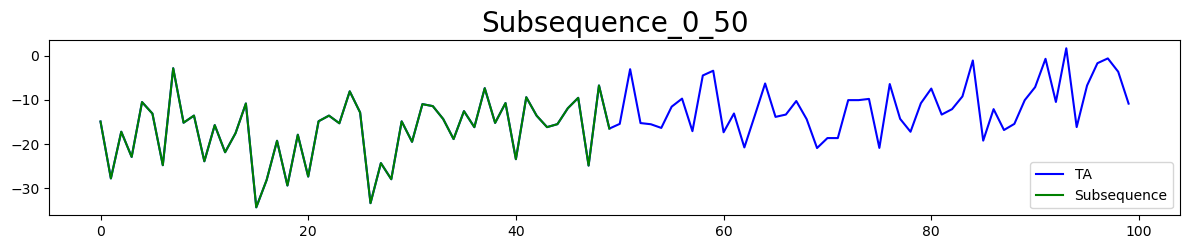

In [30]:
mplots.plot_subsequence(
    TA = ts[:100], 
    sequence_i = 0,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

And what happens if we use the double?

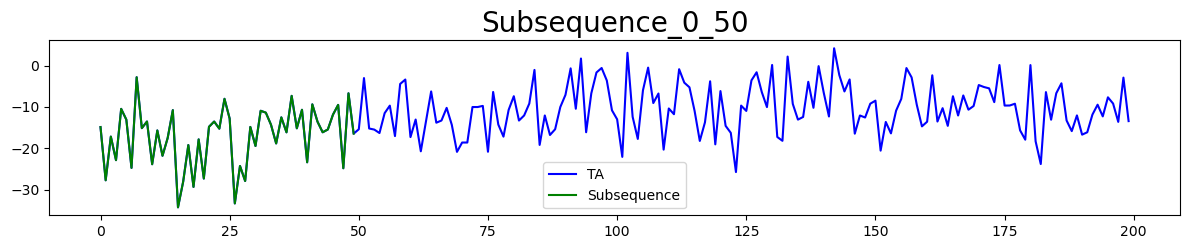

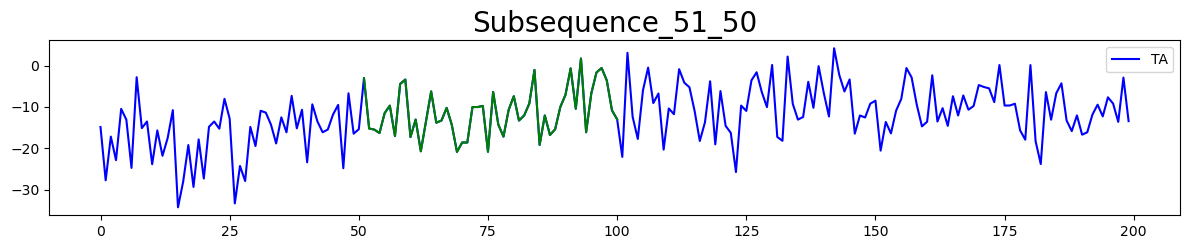

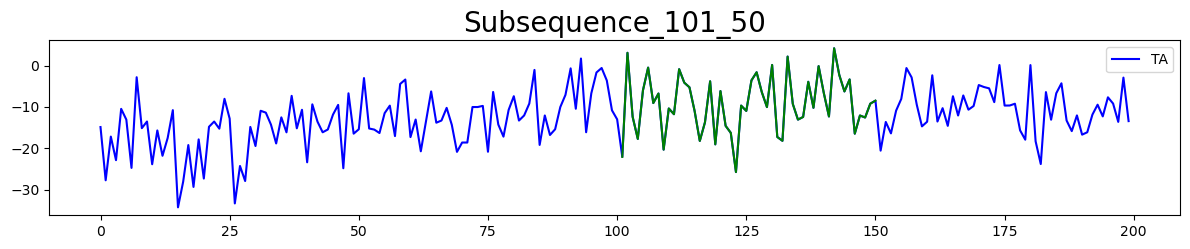

In [31]:
mplots.plot_subsequence(
    TA = ts[:200], 
    sequence_i = 0,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts[:200], 
    sequence_i = m+1,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts[:200], 
    sequence_i = 2*m+1,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

This value seems to correspond to that idea of getting 'one pulsus' as subsequence length

### Compute the Matrix Profile

In [32]:
pulsus_mp.subsequence_len = m

In [33]:
pulsus_mp.compute(
    print_flag = True, 
    d = mplots.z_normalized_euclidean_distance, 
    method = 'stump'
)

--> matrix profile
--> Stump (CPU)
MP | Compute | Using stumpy.stump | normalize? True
matrix profile 20.890562295913696 seconds -->


array([6.765568992161627, 6.766453552922352, 6.8389931213395485, ...,
       6.8596378651192955, 6.86627650375321, 6.871343235133684],
      dtype=object)

In [34]:
len(pulsus_mp.index)

28751

### Visualization of the matrix profile

With the interactive plot we can visually check the motif and anomaly indexes.
The previous and next buttons can be used for going subsequence by subsequence whereas the Motif and Discord buttons show the associated subsequences.

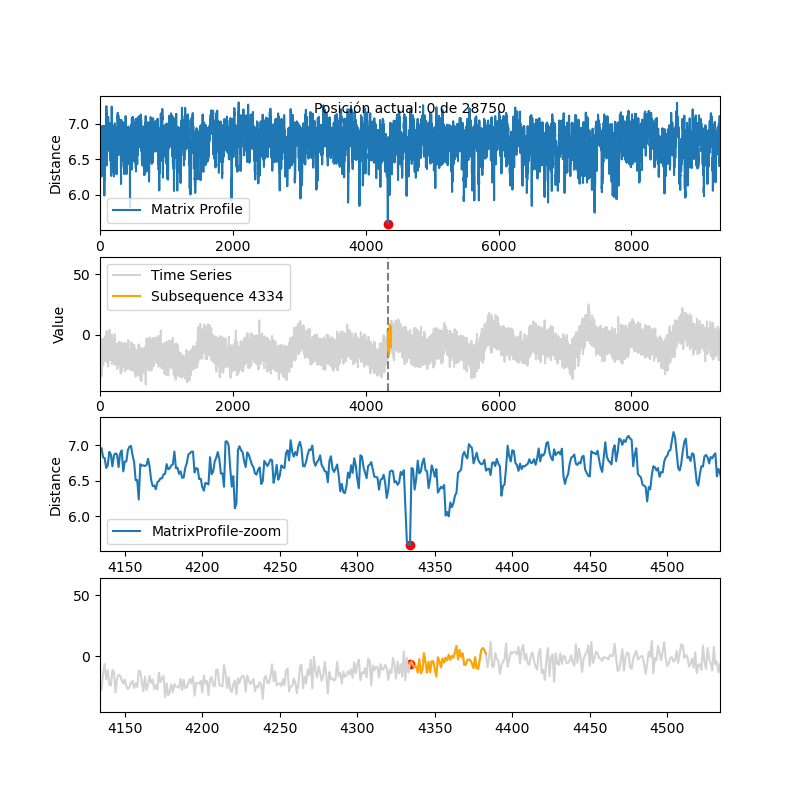

In [35]:
%matplotlib widget
pulsus_mp.plot_interactive(
    figsize = (8,8),
    print_flag =  False
)

### Direct computation & related metadata

#### Motif

In [36]:
pulsus_mp.get_motif_idx(print_flag = print_flag)

motif id 4334 index ~  28751


(4334, 25879, 4245, 25879)

In [37]:
print(pulsus_mp.motif_idx)
print(pulsus_mp.motif_nearest_neighbor_idx)
print(pulsus_mp.motif_nearest_neighbor_idx_left)
print(pulsus_mp.motif_nearest_neighbor_idx_right)


4334
25879
4245
25879


#### Discord/Anomaly

In [38]:
pulsus_mp.get_anomaly_idx(print_flag = print_flag)

motif id 17091 index ~  28751
Nearest  10450
Nearest left  10450
Nearest right  27504


(17091, 10450, 10450, 27504)

In [39]:
print(pulsus_mp.discord_idx)
print(pulsus_mp.discord_nearest_neighbor_idx)
print(pulsus_mp.discord_nearest_neighbor_idx_left)
print(pulsus_mp.discord_nearest_neighbor_idx_right)

17091
10450
10450
27504


## Check the MPlot

### Build the MatrixProfilePlot object

In [40]:
data_MPlot = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

In [41]:
#| hide
print("MP_AB self_join", data_MPlot.MP_AB.self_join)
print(f"DM_AB ~ {data_MPlot.DM_AB.shape}")
print("MP_AB method:", data_MPlot.MP_AB.method)
print("DM_AB method:", data_MPlot.DM_AB.method)

MP_AB self_join True
DM_AB ~ (0, 0)
MP_AB method: naive
DM_AB method: naive


### Compute the Similarity Matrix

In [42]:
data_MPlot.subsequence_len

50

In [59]:
# z-normalized euclidean distance
from scipy.stats import zscore
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import correlation
def zeuclidean(u,v): return euclidean(zscore(u), zscore(v));
def distance(u,v):
    #-- euclidean
    return euclidean(u,v)
    #-- z_normalized euclidean
    #return zeuclidean(u,v)
    #-- Pearson correlation
    #return correlation(u,v)

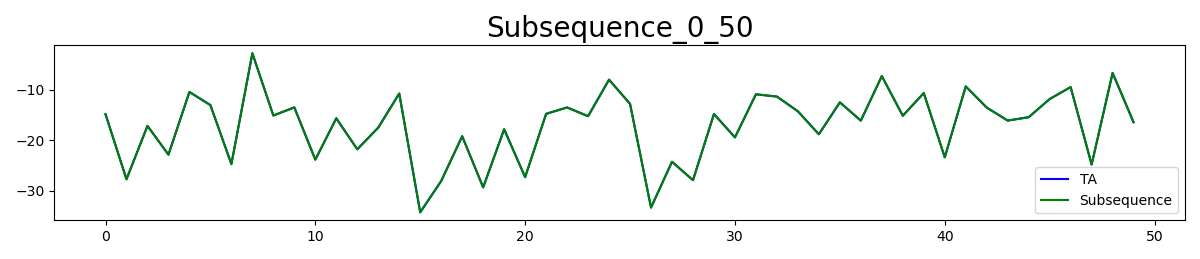

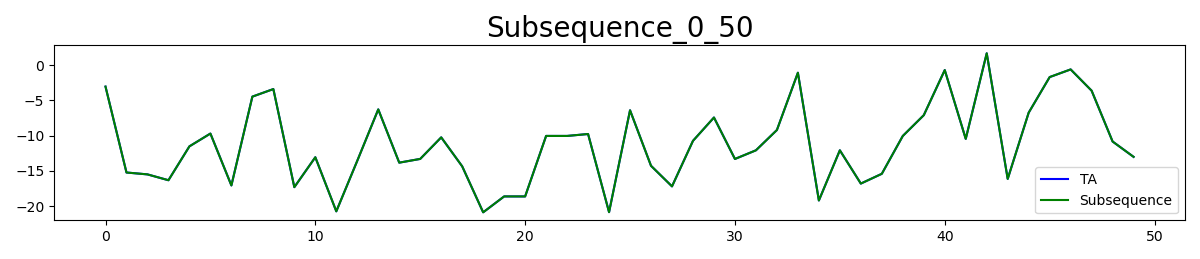

In [61]:
mplots.plot_subsequence(
    TA = ts[:50], 
    sequence_i = 0,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)
mplots.plot_subsequence(
    TA = ts[51:101], 
    sequence_i = 0,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images"
)

In [44]:
data_MPlot.compute(
    mp_method           = 'stump', 
    dm_method          = 'scamp',
    d                   = distance,
    print_flag          = True,
    debug               = False,
    time_flag           = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    max_points          = 10000,
    #nlens              = 5,
    provide_len         = False,
    subsequence_len     = data_MPlot.subsequence_len, #Revisar por qué no pilla bien coger el subsequence_len de los atributos
    downsample_flag     = False,
    min_lag             = 8,
    print_depth         = 0,
    threads             = 1,
    gpus                = [1]
)

MPlot | Compute | Do not downsample => use original time series
[ MPlot | Compute ] | Ensure Parameters TB_paa ~ 28800 ---> 
Ensure valid limits | Original [0, 28800]
Final [0, 28800]
Ensure valid limits | Original [0, 28800]
Final [0, 28800]
--> matrix profile
matrix profile 17.303457260131836 seconds -->


### Check the obtained values

In [45]:
print(data_MPlot.subsequence_len)

50


In [46]:
n_a = len(data_MPlot.data)
n_b = len(data_MPlot.data_b)
print("-- DM Expected dimensions -- ")
print("Rows: ", n_b - data_MPlot.subsequence_len + 1)
print("Columns: ", n_a - data_MPlot.subsequence_len + 1)
print(f"-- Obtained shape when computing using  {data_MPlot.DM_AB.method} --")
print(data_MPlot.DM_AB.shape)
print(f"-- MP dimension using {data_MPlot.MP_AB.method}")
print(len(data_MPlot.MP_AB.distances))
print("-- DM Values --")
print(data_MPlot.DM_AB.distances)
print("-- MP values --")
print(data_MPlot.MP_AB.distances)

-- DM Expected dimensions -- 
Rows:  28751
Columns:  28751
-- Obtained shape when computing using  scamp --
(28751, 28751)
-- MP dimension using stump
28751
-- DM Values --
[[10.19803903 10.19803903 10.19803903 ... 10.00500763  9.98921259
   9.96829543]
 [        inf         inf         inf ... 10.00749271 10.00479544
   9.98960961]
 [        inf         inf         inf ... 10.01617117 10.00640911
  10.00365141]
 ...
 [10.00500763 10.00749271 10.01617117 ...         inf         inf
          inf]
 [ 9.98921259 10.00479544 10.00640911 ...         inf         inf
          inf]
 [ 9.96829543  9.98960961 10.00365141 ...         inf         inf
          inf]]
-- MP values --
[46.75708768592813 46.067076667741524 46.76204204189062 ...
 46.109681125032935 46.119444454104006 46.458135860700274]


### Visualize the plot

##### Motif found by MP

Motif found using MP
13892
Plotted: ts[13842,13992] => 13892 subsequence index changes to 50


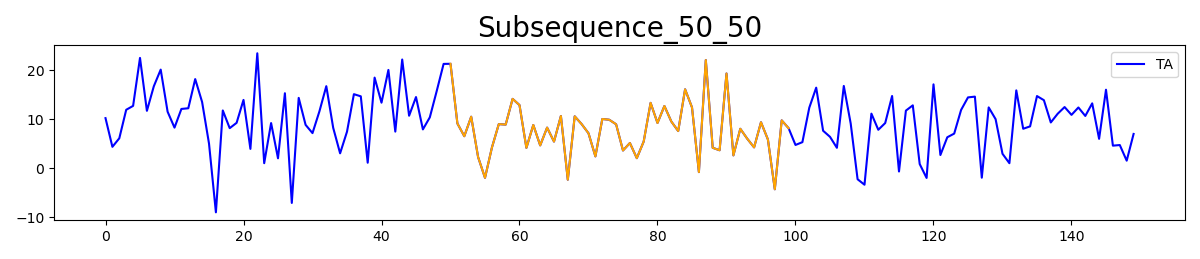

In [47]:
print("Motif found using MP")
data_MPlot.MP_AB.get_motif_idx()
print(data_MPlot.MP_AB.motif_idx)

init = data_MPlot.MP_AB.motif_idx - m
final = init+3*m
print(f"Plotted: ts[{init},{final}] => {data_MPlot.MP_AB.motif_idx} subsequence index changes to {data_MPlot.MP_AB.motif_idx-init}")

mplots.plot_subsequence(
    TA = ts[init:final],
    sequence_i = data_MPlot.MP_AB.motif_idx-init,
    subsequence_len = m,
    dots = False,
    sequence_flag = False,
    save_plot = True,
    plot_path = "./images",
    subsequence_color = "orange"
)


Before: Pos 0 Add 0
Plot Interactive | After: Pos 0 Selected index 13892
Plot Interactive | Distances:  [46.75708768592813 46.067076667741524 46.76204204189062 ...
 46.109681125032935 46.119444454104006 46.458135860700274]
Plot Interactive | Window [12392, 15392]


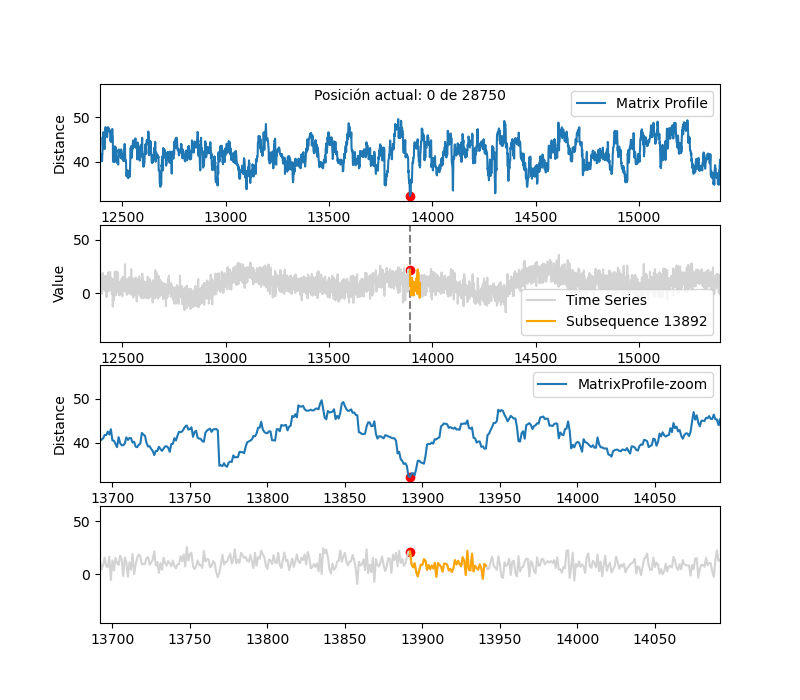

In [48]:
%matplotlib widget
# Max points to plot
data_MPlot.MP_AB.max_points = 3000
data_MPlot.MP_AB.plot_interactive(print_flag = True, figsize=(8,7))

#### Setting up a threshold

It has been checked that, at least for pulsus raxodus, STUMP separates more the distances than SCAMP, so the proposed thresholds show similar plots for the specific case.

In [49]:
# Threshold per method
threshold_scamp = 10
threshold_stump = 7.5
# Select the threshold for the method used for the computation
threshold = threshold_stump if data_MPlot.DM_AB.method == 'stump' else threshold_scamp

#### Visualizing the MPlot in gray scale

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;TODO: check, the gray_color flag is in the opposite way... 
    </div>
</div>

- El patrón es el mismo, cada vez un poco más para arriba
- Eso significa que la distancia debe ser cada vez un poco mayor entre unos y otros (en este caso de manera constante)
- Si miro una fila/columna de la matriz de similitud, debería ser cada número (saltando de m en m) un poco mayor que el siguiente
- En los colores se debería ver cada vez más distancia entre unos y otros. 

In [50]:
print(data_MPlot.DM_AB.distances[0][0:m+1])
print(data_MPlot.DM_AB.distances[0][m:2*m+1])
total = len(data_MPlot.DM_AB.distances[0])
print(data_MPlot.DM_AB.distances[0][total:total-m+1])


[10.19803903 10.19803903 10.19803903 10.19803903 10.19803903 10.19803903
 10.19803903 10.19803903  9.99759804  9.99944648  9.97168889 10.00239108
  9.98865797  9.99193558  9.98007186  9.99218769  9.99571007  9.98419324
  9.99526246 10.00501937  9.99358751 10.01104754  9.99901538 10.01250752
  9.99141231  9.99568015  9.99648695  9.98090886  9.98956875 10.00288767
 10.01018936 10.00877138  9.99570019 10.02990242  9.9747512   9.98218499
 10.01859655  9.98676851 10.01395424  9.99742665 10.02251833  9.9888216
  9.98303029  9.99291591  9.99181939  9.98235579 10.01314439  9.98022547
  9.9992301   9.98710147  9.99323108]
[ 9.99323108  9.97100612  9.97195998 10.00052782  9.97037134  9.99892114
  9.99551228  9.99093901 10.00136742  9.96878991  9.96678167  9.98900372
  9.99790141 10.00984159 10.01123022  9.99791549  9.99973369  9.98963517
 10.0027958   9.9860358  10.00129737 10.01122274  9.99235501  9.99735753
 10.00010766 10.00267417 10.00348182 10.00598241 10.02926519 10.00594129
 10.02949057 1

Threshold: 10 | Mehod: scamp


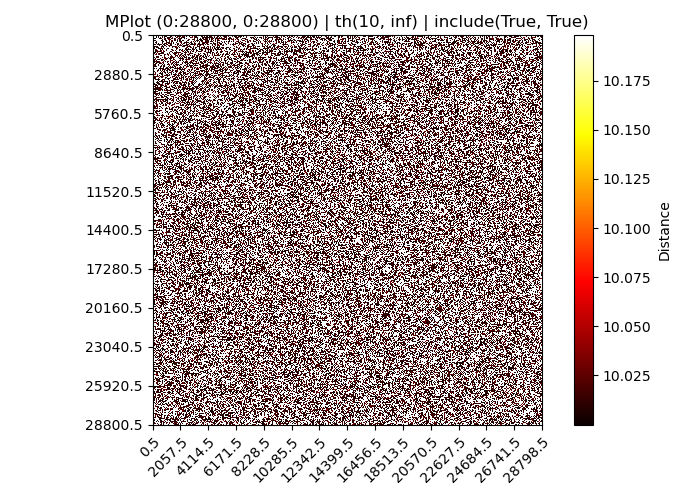

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [51]:
print(f"Threshold: {threshold} | Mehod: {data_MPlot.DM_AB.method}")

data_MPlot.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    print_flag  = False,
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = 10,
    th_max      = np.inf,
    include_min = True,
    include_max = True,
    MPlot_title = 'S3: MPlot | ' + data_MPlot.DM_AB.method,
    plot_mp_flag= False,
    gray_color  = True
)

##### Normalizing the matrix
As we can't see anything upthere, let's try normalizing the distances

In [52]:
from sklearn.preprocessing import MinMaxScaler
# Step 1: Identify and save the indices of np.inf, -np.inf and NaN
print("Identifying indices of np.inf, -np.inf and NaN")
inf_indices = np.isposinf(data_MPlot.DM_AB.distances)
neginf_indices = np.isneginf(data_MPlot.DM_AB.distances)
nan_indices = np.isnan(data_MPlot.DM_AB.distances)

# Replace np.inf and -np.inf with NaN to facilitate handling
print("Replacing np.inf and -np.inf with NaN")
simmat = np.where(np.isinf(data_MPlot.DM_AB.distances), np.nan, data_MPlot.DM_AB.distances)

# Step 2: Normalise the matrix without np.inf and NaN
print("Normalising the matrix without np.inf and NaN")
# Replace NaN with the column mean
col_means = np.nanmean(simmat, axis=0)
inds = np.where(np.isnan(simmat))
simmat[inds] = np.take(col_means, inds[1])

# Apply MinMaxScaler
print("Applying MinMaxScaler")
scaler = MinMaxScaler()
distances_normalised = scaler.fit_transform(simmat)

# Step 3: Restore np.inf, -np.inf and NaN to their original positions
print("Restoring np.inf, -np.inf and NaN to their original positions")
distances_restored = distances_normalised.copy()
distances_restored[nan_indices] = np.nan
distances_restored[inf_indices] = np.inf
distances_restored[neginf_indices] = -np.inf

# Assign the restored values back to data_MPlot.DM_AB.distances
data_MPlot.DM_AB.distances = distances_restored

# Print final information
print("Finished normalisation and restoration of special values.")
print("Summary of restored values:")
print(f"np.inf: {np.sum(inf_indices)}")
print(f"-np.inf: {np.sum(neginf_indices)}")
print(f"NaN: {np.sum(nan_indices)}")

Identifying indices of np.inf, -np.inf and NaN
Replacing np.inf and -np.inf with NaN
Normalising the matrix without np.inf and NaN
Applying MinMaxScaler
Restoring np.inf, -np.inf and NaN to their original positions
Finished normalisation and restoration of special values.
Summary of restored values:
np.inf: 488686
-np.inf: 0
NaN: 0


In [53]:
data_MPlot.DM_AB.distances

array([[1.        , 1.        , 1.        , ..., 0.53164444, 0.38630517,
        0.19472738],
       [       inf,        inf,        inf, ..., 0.55438655, 0.52892839,
        0.39031785],
       [       inf,        inf,        inf, ..., 0.63380716, 0.54369755,
        0.51917298],
       ...,
       [0.23525856, 0.24506781, 0.27660739, ...,        inf,        inf,
               inf],
       [0.17268262, 0.23438142, 0.23777809, ...,        inf,        inf,
               inf],
       [0.08981414, 0.17421615, 0.22680916, ...,        inf,        inf,
               inf]])

This is the new plot

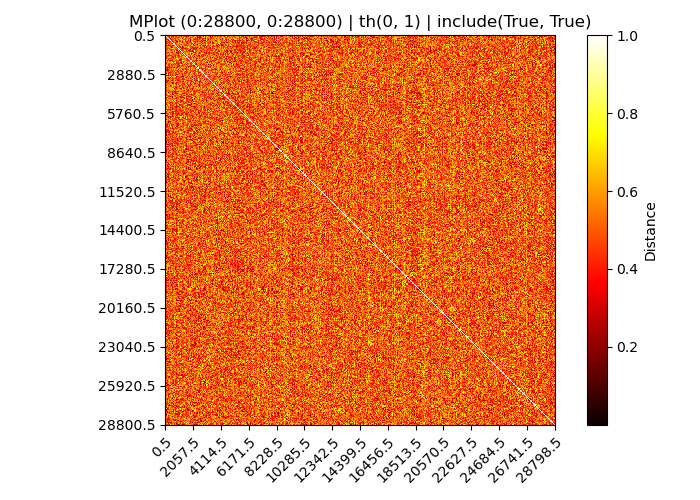

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [54]:
data_MPlot.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    print_flag  = False,
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = 0,
    th_max      = 1,
    include_min = True,
    include_max = True,
    MPlot_title = 'S3: MPlot | ' + data_MPlot.DM_AB.method,
    plot_mp_flag= False,
    gray_color  = True
)

It seems most of the values are between 0.6 and 0.8. Lets check again

Plot check limits | Original range: r( None , None ) c( None , None )
Plot check limits | CRange0: r( 0 , 28800 ) c( None , None )
Plot check limits | CRange1: r( 0 , 28800 ) c( 0 , None )
Plot check limits | CRange2: r( 0 , 28800 ) c( 0 , 28800 )
Plot check limits | Final range: r( 0 , 28800 ) c( 0 , 28800 )
r_start 0
r_end 28800
c_start 0
c_end 28800
nr 28801
nc 28801
MPlot | Plot DM | DM_AB[0:28800, 0:28800] ~ (28751, 28751)
Plotting as MATLAB


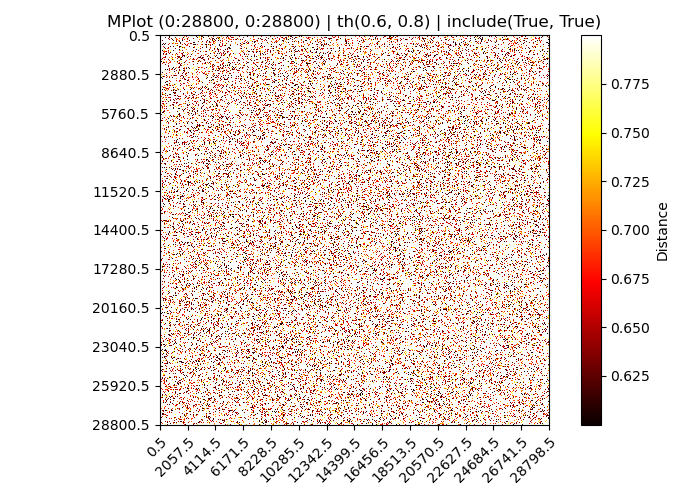

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [55]:
data_MPlot.plot(
    ts_name     = 'Variable 0',
    figsize     = (7,5),
    print_flag  = True,
    less_labels = True,
    # debug_flag  = False,
    dm_filter   = mplots.threshold_interval,
    th_min      = 0.6,
    th_max      = 0.8,
    include_min = True,
    include_max = True,
    MPlot_title = 'S3: MPlot | ' + data_MPlot.DM_AB.method,
    plot_mp_flag= False,
    gray_color  = True
)

#### Zoom!

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;Remember that in MPlots zooming in-out is not recommended due to the approximations. Thus. We directly show the specific part 
    </div>
</div>

In [56]:
print(len(data_MPlot.DM_AB.distances))
print(len(data_MPlot.DM_AB.distances)-90)

28751
28661


Threshold:  10
Plot check limits | Original range: r( 0 , 90 ) c( 28661 , 28751 )
Plot check limits | CRange0: r( 0 , 90 ) c( 28661 , 28751 )
Plot check limits | CRange1: r( 0 , 90 ) c( 28661 , 28751 )
Plot check limits | CRange2: r( 0 , 90 ) c( 28661 , 28751 )
Plot check limits | Final range: r( 0 , 90 ) c( 28661 , 28751 )
r_start 0
r_end 90
c_start 28661
c_end 28751
nr 91
nc 91
MPlot | Plot DM | DM_AB[0:90, 28661:28751] ~ (0, 28751)
Plotting as MATLAB


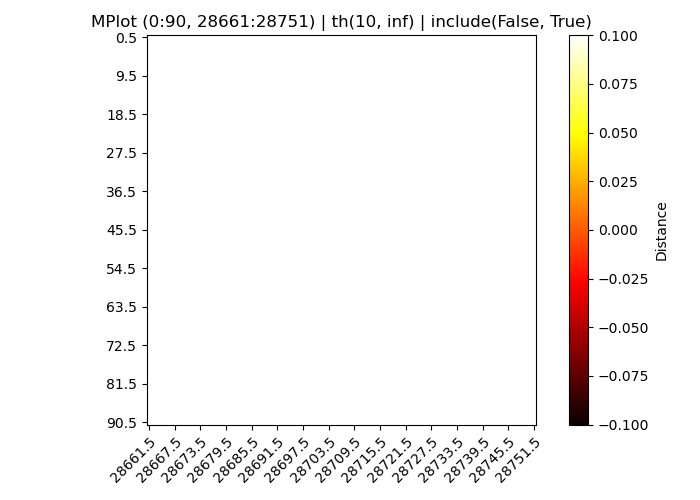

<module 'matplotlib.pyplot' from '/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [57]:
print("Threshold: ", threshold)
data_MPlot.plot(
    ts_name      = 'Variable 0',
    figsize      = (7,5),
    print_flag   = True,
    less_labels  = True,
    r_min        = 0,
    r_max        = 90,
    c_min        = 28661,
    c_max        = 28751,
    dm_filter    = mplots.threshold_interval,
    th_min       = threshold,
    th_max       = np.inf,
    include_min  = False,
    include_max  = True,
    gray_color   = True,
    plot_mp_flag = False,
    print_depth  = 1
)

#### Zoom with colors!

In [58]:
print("Threshold: ", threshold)
data_MPlot.plot(
    ts_name      = 'Variable 0',
    figsize      = (7,5),
    print_flag   = True,
    less_labels  = True,
    r_min        = r_min,
    r_max        = r_max,
    c_min        = c_min,
    c_max        = c_max,
    dm_filter    = mplots.threshold_interval,
    th_min       = 7.5,
    th_max       = np.inf,
    include_min  = True,
    include_max  = True,
    gray_color   = True,
    plot_mp_flag = False,
    print_depth  = 1
)

Threshold:  10


NameError: name 'r_min' is not defined

#### And what about computing only the part of the plot I need?

In [ ]:
data_MPlot2 = mplots.MatrixProfilePlot(
    DM_AB           = mplots.DistanceMatrix(), 
    MP_AB           = mplots.MatrixProfile(),
    data            = ts, 
    data_b          = ts,
    subsequence_len = pulsus_mp.subsequence_len,
    self_join       = False
)

In [ ]:
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

In [ ]:
data_MPlot2.compute(
    mp_method           = 'stump', 
    #mp_method          = "scamp_naive" --> Devuelve siempre 0 en el ejemplo de Pulsus Raxodus | why?
    dm_method           = 'stump',
    #dm_method          = 'scamp',
    d = mplots.z_normalized_euclidean_distance,
    print_flag          = True,
    debug               = False,
    time_flag           = True,
    #allow_experimental  = True,
    allow_experimental  = False,
    ensure_symetric     = False,
    c_min               = r_min,
    c_max               = r_max,
    r_min               = c_min, 
    r_max               = c_max,
    max_points          = 10000,
    #nlens              = 5,
    #provide_len        = True,
    provide_len         = False,
    subsequence_len     = data_MPlot.subsequence_len,
    downsample_flag     = False,
    min_lag             = 8, #4
    print_depth         = 0,
    threads             = 1,
    gpus                = [1]
)

In [ ]:
c = (c_min, c_max)
r = (r_min, r_max)
print(f"c: {c}, r: {r}")

In [ ]:
print(data_MPlot.DM_AB.shape)
print(data_MPlot2.DM_AB.shape)

<div style="background-color: yellow; color: red; padding: 15px; border-radius: 5px; border: 2px solid red; display: flex; align-items: center; margin: 20px 0;">
    <span style="font-size: 30px; font-weight: bold; margin-right: 10px;">&#9888;</span>
    <div>
        <strong>Warning:</strong>&nbsp;&nbsp;Take care... some dyslexia is beeing fixed here. Use columns as rows and rows as columns.
    </div>
</div>

In [ ]:
warnings.simplefilter('always', UserWarning)

In [ ]:
# The mistery of indexes is still being solved
print("Threshold: ", threshold)
data_MPlot2.plot(
    ts_name      = 'Variable 0',
    figsize      = (7,5),
    print_flag   = True,
    less_labels  = True,
    r_min        = c_min,
    r_max        = c_max,
    c_min        = r_min,
    c_max        = r_max,
    dm_filter    = mplots.threshold_interval,
    th_min       = threshold,
    th_max       = np.inf,
    include_min  = True,
    include_max  = True,
    gray_color   = False,
    plot_mp_flag = False,
    print_depth  = 1
)

In [ ]:
run.finish

In [ ]:
if reset_kernel:
    os._exit(00)